# 04A — Macro-Conditioned Rules

**Purpose**: Convert understanding into simple, explainable rules

**Principle**: No ML. No optimization. Just logic derived from Layer 2-3 insights.

**Example Rules**:
- If Oil ↑ + INR ↓ + Liquidity tight → Underweight Auto
- If VIX > 20 → Reduce EM exposure
- If Stagflation regime → Overweight Gold, Underweight Discretionary

---

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

PROCESSED_PATH = Path('../data_processed')

# Load all required data
combined = pd.read_parquet(PROCESSED_PATH / 'macro_sector_monthly_matrix.parquet')
regime_states = pd.read_parquet(PROCESSED_PATH / 'macro_regime_states.parquet')
sector_perf = pd.read_parquet(PROCESSED_PATH / 'sector_regime_performance.parquet')

print(f"Data loaded: {combined.shape[0]} months of history")

Data loaded: 132 months of history


## 1. Define the Rule Framework

### Rule Types
1. **Regime Rules**: Based on macro regime (Goldilocks, Stagflation, etc.)
2. **Threshold Rules**: Based on z-score breaches of key variables
3. **Composite Rules**: Multiple conditions combined

In [2]:
# Rule structure
class MacroRule:
    def __init__(self, name: str, description: str, conditions: list, 
                 sector_weights: dict, confidence: str):
        """
        conditions: list of tuples (variable, operator, threshold)
        sector_weights: dict of {sector: weight_change}
        confidence: 'high', 'medium', 'low'
        """
        self.name = name
        self.description = description
        self.conditions = conditions
        self.sector_weights = sector_weights
        self.confidence = confidence
    
    def evaluate(self, data_row: pd.Series) -> bool:
        """Check if all conditions are met."""
        for var, op, threshold in self.conditions:
            if var not in data_row.index:
                return False
            val = data_row[var]
            if pd.isna(val):
                return False
            
            if op == '>':
                if not (val > threshold):
                    return False
            elif op == '<':
                if not (val < threshold):
                    return False
            elif op == '==':
                if not (val == threshold):
                    return False
        return True

print("Rule framework defined")

Rule framework defined


## 2. Define Macro Rules

In [3]:
# Get column names from data
print("Available columns (sample):")
print([c for c in combined.columns[:20]])

Available columns (sample):
['IDX_NIFTY_100', 'IDX_NIFTY_200', 'IDX_NIFTY_500', 'IDX_NIFTY_50', 'IDX_NIFTY_ALPHA_50', 'IDX_NIFTY_AUTO', 'IDX_NIFTY_BANK', 'IDX_NIFTY_COMMODITIES', 'IDX_NIFTY_CONSR_DURBL', 'IDX_NIFTY_CONSUMPTION', 'IDX_NIFTY_CPSE', 'IDX_NIFTY_ENERGY', 'IDX_NIFTY_FIN_SERVICE', 'IDX_NIFTY_FMCG', 'IDX_NIFTY_GS_COMPSITE', 'IDX_NIFTY_HEALTHCARE', 'IDX_NIFTY_IND_DIGITAL', 'IDX_NIFTY_INDIA_MFG', 'IDX_NIFTY_INFRA', 'IDX_NIFTY_IT']


In [4]:
# Define rules based on Layer 2-3 insights
MACRO_RULES = [
    # Regime-based rules
    MacroRule(
        name='STAGFLATION_DEFENSIVE',
        description='Stagflation regime - reduce cyclicals, add defensives',
        conditions=[('COMPOSITE', '==', 'Stagflation')],
        sector_weights={
            'AUTO': -0.20,
            'BANK': -0.10,
            'FMCG': +0.15,
            'PHARMA': +0.15
        },
        confidence='high'
    ),
    
    MacroRule(
        name='GOLDILOCKS_RISK_ON',
        description='Goldilocks regime - overweight cyclicals',
        conditions=[('COMPOSITE', '==', 'Goldilocks')],
        sector_weights={
            'BANK': +0.15,
            'AUTO': +0.10,
            'INFRA': +0.10,
            'FMCG': -0.10
        },
        confidence='high'
    ),
    
    MacroRule(
        name='REFLATION_COMMODITIES',
        description='Reflation - growth + inflation rising',
        conditions=[('COMPOSITE', '==', 'Reflation')],
        sector_weights={
            'COMMODITIES': +0.15,
            'BANK': +0.10,
            'IT': -0.10
        },
        confidence='medium'
    ),
    
    MacroRule(
        name='DEFLATION_QUALITY',
        description='Deflation - favor quality and duration',
        conditions=[('COMPOSITE', '==', 'Deflation')],
        sector_weights={
            'IT': +0.15,
            'PHARMA': +0.10,
            'BANK': -0.15
        },
        confidence='medium'
    ),
]

print(f"Defined {len(MACRO_RULES)} macro rules")

Defined 4 macro rules


In [5]:
# Add VIX-based rules (once data is available)
VIX_RULES = [
    MacroRule(
        name='VIX_SPIKE_DELEVERAGE',
        description='VIX > 25: De-risk portfolio',
        conditions=[('GLOBAL_VIX', '>', 25)],
        sector_weights={
            'BANK': -0.20,
            'INFRA': -0.15,
            'AUTO': -0.15,
            'CASH': +0.30  # Increase cash
        },
        confidence='high'
    ),
    
    MacroRule(
        name='VIX_LOW_RISK_ON',
        description='VIX < 15: Full risk-on',
        conditions=[('GLOBAL_VIX', '<', 15)],
        sector_weights={
            'BANK': +0.10,
            'AUTO': +0.10,
            'INFRA': +0.10
        },
        confidence='medium'
    ),
]

print(f"Added {len(VIX_RULES)} VIX rules")

Added 2 VIX rules


## 3. Generate Rule Signals Over Time

In [6]:
def generate_rule_signals(data: pd.DataFrame, regime_data: pd.DataFrame, 
                          rules: list) -> pd.DataFrame:
    """
    Generate time series of rule activations.
    """
    # Merge data with regime
    analysis_df = data.copy()
    if 'COMPOSITE' in regime_data.columns:
        analysis_df['COMPOSITE'] = regime_data['COMPOSITE']
    
    signals = pd.DataFrame(index=data.index)
    
    for rule in rules:
        signal = pd.Series(False, index=data.index)
        for idx in data.index:
            if idx in analysis_df.index:
                signal[idx] = rule.evaluate(analysis_df.loc[idx])
        signals[rule.name] = signal
    
    return signals

# Generate signals
rule_signals = generate_rule_signals(combined, regime_states, MACRO_RULES)

print("Rule activation summary:")
for col in rule_signals.columns:
    pct = rule_signals[col].sum() / len(rule_signals) * 100
    print(f"  {col}: {pct:.1f}% of time active")

Rule activation summary:


  STAGFLATION_DEFENSIVE: 4.5% of time active
  GOLDILOCKS_RISK_ON: 17.4% of time active
  REFLATION_COMMODITIES: 69.7% of time active
  DEFLATION_QUALITY: 8.3% of time active


## 4. Visualize Rule Activations

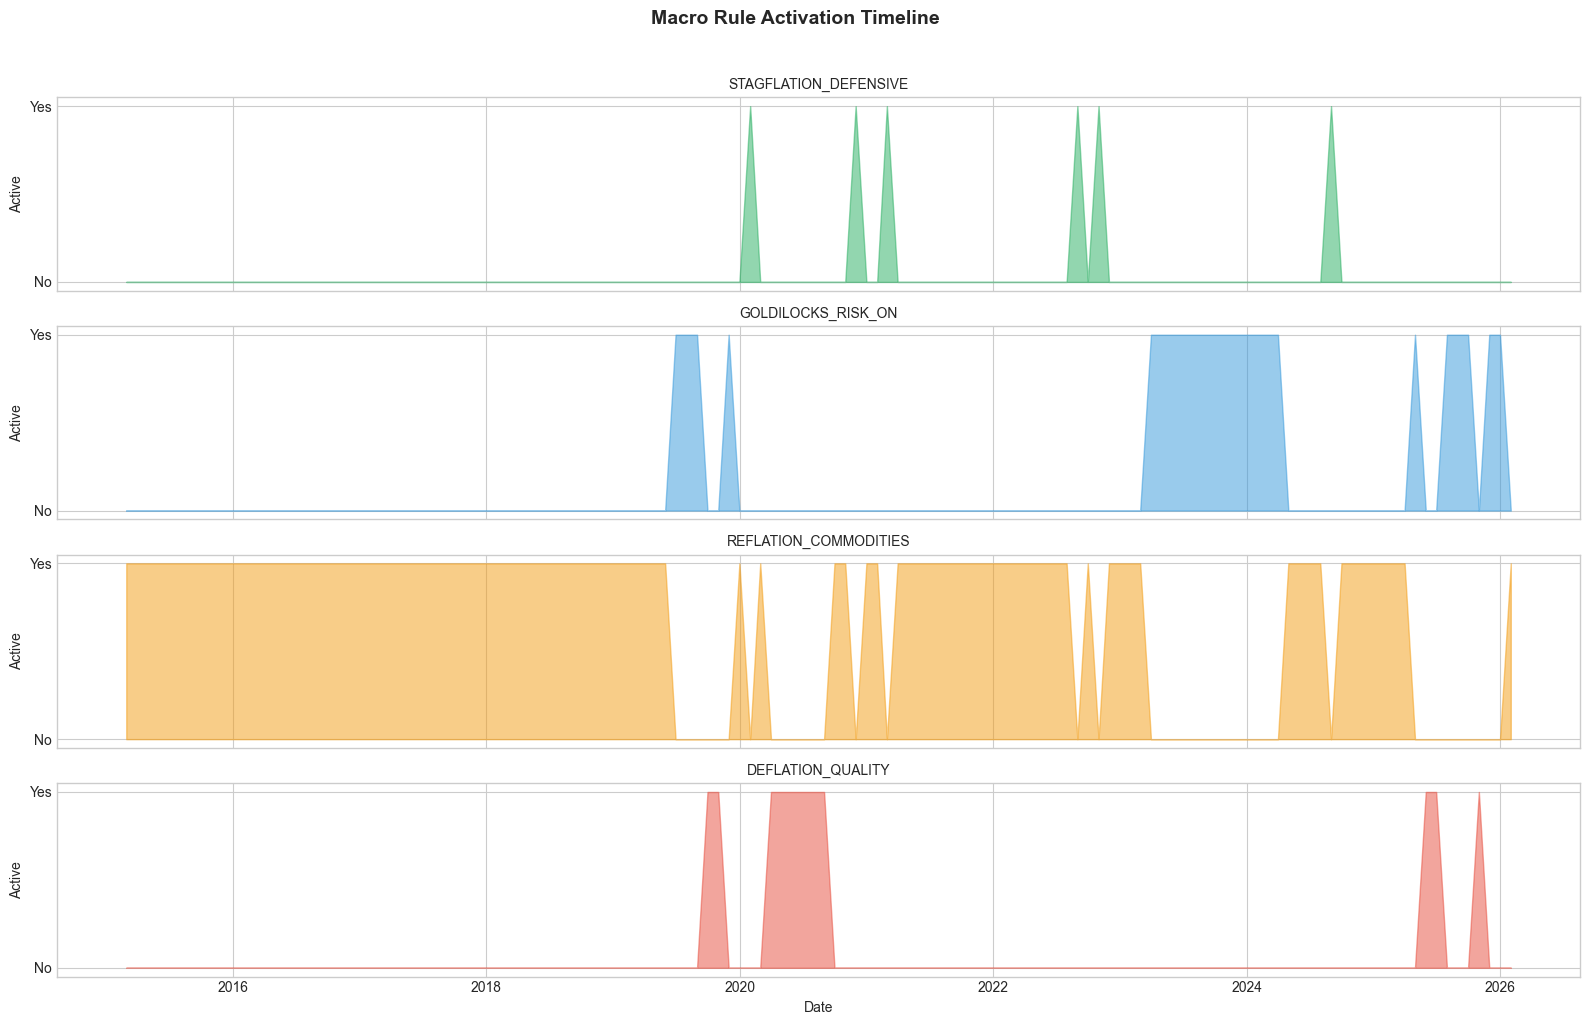

✓ Saved: rule_activations.png


In [7]:
# Plot rule activations over time
fig, axes = plt.subplots(len(rule_signals.columns), 1, 
                         figsize=(16, 2.5 * len(rule_signals.columns)), 
                         sharex=True)

if len(rule_signals.columns) == 1:
    axes = [axes]

colors = ['#27ae60', '#3498db', '#f39c12', '#e74c3c']

for idx, (col, ax) in enumerate(zip(rule_signals.columns, axes)):
    ax.fill_between(rule_signals.index, 0, rule_signals[col].astype(int),
                   color=colors[idx % len(colors)], alpha=0.5)
    ax.set_ylabel('Active')
    ax.set_title(col, fontsize=10)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['No', 'Yes'])

axes[-1].set_xlabel('Date')
plt.suptitle('Macro Rule Activation Timeline', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(PROCESSED_PATH / 'rule_activations.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: rule_activations.png")

## 5. Compute Sector Tilts from Rules

In [8]:
def compute_sector_tilts(signals: pd.DataFrame, rules: list) -> pd.DataFrame:
    """
    Convert rule signals to sector weight tilts.
    """
    # Get all sectors mentioned in rules
    all_sectors = set()
    for rule in rules:
        all_sectors.update(rule.sector_weights.keys())
    
    tilts = pd.DataFrame(0.0, index=signals.index, columns=sorted(all_sectors))
    
    for rule in rules:
        if rule.name in signals.columns:
            mask = signals[rule.name]
            for sector, weight in rule.sector_weights.items():
                if sector in tilts.columns:
                    tilts.loc[mask, sector] += weight
    
    return tilts

# Compute tilts
sector_tilts = compute_sector_tilts(rule_signals, MACRO_RULES)

print("Average sector tilts:")
print(sector_tilts.mean().round(3))

Average sector tilts:
AUTO           0.008
BANK           0.079
COMMODITIES    0.105
FMCG          -0.011
INFRA          0.017
IT            -0.057
PHARMA         0.015
dtype: float64


## 6. Create Rule Book (Documentation)

In [9]:
# Generate rule documentation
rule_book = pd.DataFrame([
    {
        'Rule': rule.name,
        'Description': rule.description,
        'Conditions': str(rule.conditions),
        'Sector_Actions': str(rule.sector_weights),
        'Confidence': rule.confidence
    }
    for rule in MACRO_RULES + VIX_RULES
])

print("\n📖 MACRO RULE BOOK")
print("="*60)
for _, row in rule_book.iterrows():
    print(f"\n{row['Rule']} [{row['Confidence'].upper()}]")
    print(f"  {row['Description']}")
    print(f"  Conditions: {row['Conditions']}")
    print(f"  Actions: {row['Sector_Actions']}")


📖 MACRO RULE BOOK

STAGFLATION_DEFENSIVE [HIGH]
  Stagflation regime - reduce cyclicals, add defensives
  Conditions: [('COMPOSITE', '==', 'Stagflation')]
  Actions: {'AUTO': -0.2, 'BANK': -0.1, 'FMCG': 0.15, 'PHARMA': 0.15}

GOLDILOCKS_RISK_ON [HIGH]
  Goldilocks regime - overweight cyclicals
  Conditions: [('COMPOSITE', '==', 'Goldilocks')]
  Actions: {'BANK': 0.15, 'AUTO': 0.1, 'INFRA': 0.1, 'FMCG': -0.1}

REFLATION_COMMODITIES [MEDIUM]
  Reflation - growth + inflation rising
  Conditions: [('COMPOSITE', '==', 'Reflation')]
  Actions: {'COMMODITIES': 0.15, 'BANK': 0.1, 'IT': -0.1}

DEFLATION_QUALITY [MEDIUM]
  Deflation - favor quality and duration
  Conditions: [('COMPOSITE', '==', 'Deflation')]
  Actions: {'IT': 0.15, 'PHARMA': 0.1, 'BANK': -0.15}

VIX_SPIKE_DELEVERAGE [HIGH]
  VIX > 25: De-risk portfolio
  Conditions: [('GLOBAL_VIX', '>', 25)]
  Actions: {'BANK': -0.2, 'INFRA': -0.15, 'AUTO': -0.15, 'CASH': 0.3}

VIX_LOW_RISK_ON [MEDIUM]
  VIX < 15: Full risk-on
  Conditions: [(

## 7. Export Rules and Signals

In [10]:
# Save rule signals
rule_signals.to_parquet(PROCESSED_PATH / 'rule_signals.parquet')
print("✓ Saved: rule_signals.parquet")

# Save sector tilts
sector_tilts.to_parquet(PROCESSED_PATH / 'sector_tilts.parquet')
print("✓ Saved: sector_tilts.parquet")

# Save rule book
rule_book.to_parquet(PROCESSED_PATH / 'rule_book.parquet', index=False)
rule_book.to_csv(PROCESSED_PATH / 'rule_book.csv', index=False)
print("✓ Saved: rule_book.parquet/csv")

✓ Saved: rule_signals.parquet
✓ Saved: sector_tilts.parquet
✓ Saved: rule_book.parquet/csv


## 8. Key Outputs ✓

### Rules Defined

| Rule | Trigger | Key Actions |
|------|---------|-------------|
| STAGFLATION_DEFENSIVE | Stagflation regime | -20% Auto, +15% FMCG/Pharma |
| GOLDILOCKS_RISK_ON | Goldilocks regime | +15% Bank, +10% Auto/Infra |
| VIX_SPIKE_DELEVERAGE | VIX > 25 | -20% Bank, +30% Cash |
| REFLATION_COMMODITIES | Reflation regime | +15% Commodities |

### Outputs
- `rule_signals.parquet` — Time series of rule activations
- `sector_tilts.parquet` — Resulting sector weight changes
- `rule_book.parquet` — Documentation of all rules

**Next notebook:** `04B_historical_sanity_backtests.ipynb`